In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.metrics import (f1_score, auc, roc_curve, confusion_matrix,
                             roc_auc_score, matthews_corrcoef)
import seaborn as sns
mpl.style.use("seaborn-deep")



from typing import Tuple, Callable, Dict, Optional, Union, List
from joblib import Parallel, delayed

In [2]:
os.path.exists("../results/CNN/binary_class.csv")


True

# Full Results from DA Detection Paper
## Overview
This notebook can be run to reproduce all figues and results from the BHK lab's DA detection paper. The raw output from the CNN and the Sinogram-based detection (SBD) algorithm should be saved locally for this notebook to run locally.

## Performance Metrics
The following metrics are computed for this study.
### Binary Classification
#### Mathews Correlation Coefficient (MCC)
$$ \text{MCC} = {\frac {{\mathit {TP}}\cdot {\mathit {TN}}-{\mathit {FP}}\cdot {\mathit {FN}}}{\sqrt {({\mathit {TP}}+{\mathit {FP}})({\mathit {TP}}+{\mathit {FN}})({\mathit {TN}}+{\mathit {FP}})({\mathit {TN}}+{\mathit {FN}})}}} $$

#### AUC
...


### Multiclass Classification
#### Generalized MCC
$$
{\text{MCC}}={\frac {\sum _{k}\sum _{l}\sum _{m}C_{kk}C_{lm}-C_{kl}C_{mk}}{{\sqrt {\sum _{k}(\sum _{l}C_{kl})(\sum _{k'|k'\neq k}\sum _{l'}C_{k'l'})}}{\sqrt {\sum _{k}(\sum _{l}C_{lk})(\sum _{k'|k'\neq k}\sum _{l'}C_{l'k'})}}}}
$$

In [3]:
from sklearn.utils import resample

def bootstrap_ci(y_true: np.ndarray,
                 y_pred: np.ndarray,
                 metric: Callable[[np.ndarray, np.ndarray], float],
                 n_iterations: int = 5000,
                 n_samples: int = 200,
                 n_jobs: int = -1,
                 **kwargs) -> Tuple[float, float]:
    """ Compute the confidence intervals using bootstrapping.
    
    Randomly select s subsets of the test set and calculate a distrubution of 
    the metric on those sets.
    
    Parameters :
    ------------
    y_true : np.ndarray, shape=(n_samples,)
        The ground truth values.
    y_pred : np.ndarray, shape=(n_samples,)
        The model predictions.
    metric :
        The performance metric.
    n_iterations : int, optional
        Number of times to sample the test set.
    n_samples : int, optional
        Number of samples to take in each iteration.
    n_jobs : int, optional
        Number of parallel processes to use.
    **kwargs
        Additional keyword arguments to pass to metric
    
    Returns
    -------
    tuple of two floats
        The upper and lower 95% confidence interval.
    """
    
    def inner() :
        sample_y_true, sample_y_pred = resample(y_true, y_pred, n_samples=n_samples)
        return metric(sample_y_true, sample_y_pred, **kwargs)
    estimate = metric(y_true, y_pred, **kwargs)
    boot_estimates = Parallel(n_jobs=n_jobs)(delayed(inner)() for _ in range(n_iterations))
    boot_estimates = np.array(boot_estimates)
    lower = max(0.0, np.percentile(boot_estimates, 2.5))
    upper = min(1.0, np.percentile(boot_estimates, 97.5))
    return estimate, lower, upper
    

In [4]:
def permutation_test(y_true: np.ndarray,
                     y_pred: np.ndarray,
                     metric: Callable[[np.ndarray, np.ndarray], float],
                     n_permutations: int = 5000,
                     n_jobs: int = -1,
                     **kwargs) -> Tuple[float, float]:
    r"""Compute significance of predictions using a randomized permutation test.

    The p value is computed as
    ``1/(N+1) * (sum(s(y, y_pred) >= s(perm(y), perm(y_pred)) for _ in range(N)) + 1)``
    where `s` is the performance metric and `perm` denotes a random permutation. In words,
    it is the estimated probability that a random prediction would give score at least
    as good as the actual prediction.

    Parameters
    ----------
    y_true : np.ndarray, shape=(n_samples,)
        The ground truth values.
    y_pred : np.ndarray, shape=(n_samples,)
        The model predictions.
    metric
        The performance metric.
    n_permutations, optional
        How many random permutations to use. Larger values give more
        accurate estimates but take longer to run.
    n_jobs, optional
        Number of parallel processes to use.
    **kwargs
        Additional keyword arguments passed to metric.

    Returns
    -------
    tuple of 2 floats
        The value of the performance metric and the estimated p value.
    """
    def inner():
        return metric(np.random.permutation(y_true), np.random.permutation(y_pred), **kwargs)
    estimate = metric(y_true, y_pred, **kwargs)
    perm_estimates = Parallel(n_jobs=n_jobs)(delayed(inner)() for _ in range(n_permutations))
    perm_estimates = np.array(perm_estimates)
    pval = ((perm_estimates >= estimate).sum() + 1) / (n_permutations + 1)

    return estimate, pval


In [5]:
""" Get Metrics """
# Compute metrics for different methods
metrics = pd.DataFrame(data={"SBD":np.nan, "CNN":np.nan, "3_class": np.nan, 
                             "2_class_annotation": np.nan, "3_class_annotation": np.nan},
                       index=["TPR", "FPR", "TNR", "FNR", "MCC", "MCC CI_l", "MCC CI_u","AUC"])


def tpr(labels, predictions) :
    """ True positive rate"""
    num_y = (labels == 1).sum()
    C = confusion_matrix(labels, predictions)
    tn, fp, fn, tp = C.ravel()

    return tp / num_y


def fpr(labels, predictions) :
    """ False positive rate """
    num_n = (labels == 0).sum()
    C = confusion_matrix(labels, predictions)
    tn, fp, fn, tp = C.ravel()

    return fp / num_n

def tnr(labels, predictions):
    """ true negative rate """
    # Compute overall stats
    num_n = (labels == 0).sum()
    
    # Compute confusion matrix
    C = confusion_matrix(labels, predictions)
    tn, fp, fn, tp = C.ravel()
    return tn / num_n


def fnr(labels, predictions) :
    """ False negative rate """
    num_y = (labels == 1).sum()
    C = confusion_matrix(labels, predictions)
    tn, fp, fn, tp = C.ravel()
    return fn / num_y


def get_metrics(labels, predictions, scores=None) :
    if max(labels) - 2 < 1.0e-5 :
        # If the labels are (0, 2), convert to (0, 1)
        labels = labels / 2.
        predictions = predictions / 2.
    
#     # Compute overall stats
#     num_y = (labels == 1).sum()
#     num_n = (labels == 0).sum()
    
#     # Compute confusion matrix
#     C = confusion_matrix(labels, predictions)
#     tn, fp, fn, tp = C.ravel()
        
#     tpr = tp / num_y
#     fpr = fp / num_n
#     tnr = tn / num_n
#     fnr = fn / num_y
    TPR, TPR_ci1, TPR_ci2 = bootstrap_ci(labels, predictions, tpr)
    FPR, FPR_ci1, FPR_ci2 = bootstrap_ci(labels, predictions, fpr)
    TNR, TNR_ci1, TNR_ci2 = bootstrap_ci(labels, predictions, tnr)
    FNR, FNR_ci1, FNR_ci2 = bootstrap_ci(labels, predictions, fnr)
        
    # MCC
    MCC, MCC_p = permutation_test(labels, predictions, matthews_corrcoef)
    _, MCC_ci1, MCC_ci2 = bootstrap_ci(labels, predictions, matthews_corrcoef)

    
    # AUC
    if scores is None :
        print("No scores provided")
        AUC, AUC_p = permutation_test(labels, predictions, 
                                              roc_auc_score, average='weighted')
        _, AUC_ci1, AUC_ci2 = bootstrap_ci(labels, predictions, 
                                          roc_auc_score, average='weighted')
    else :       
        AUC, AUC_p = permutation_test(labels, scores, 
                                              roc_auc_score, average='weighted')
        _, AUC_ci1, AUC_ci2 = bootstrap_ci(labels, scores, 
                                          roc_auc_score, average='weighted')

        
    
    # F1 Score
#     F1, F1_p = permutation_test(labels, predictions, f1_score, average='weighted')
    
    print("TPR: ", TPR, r"$\pm$", TPR_ci1, TPR_ci2)
    print("FPR: ", FPR, r"$\pm$", FPR_ci1, FPR_ci2)
    print('TNR: ', TNR, r"$\pm$", TNR_ci1, TNR_ci2)
    print('FNR: ', FNR, r"$\pm$", FNR_ci1, FNR_ci2)
    print('AUC: ', AUC, r"$\pm$", AUC_ci1, AUC_ci2, ", p=", AUC_p)
    print('MCC: ', MCC, r"$\pm$", MCC_ci1, MCC_ci2, ", p=", MCC_p)    
    
    return [TPR, FPR, TNR, FNR, MCC, MCC_ci1, MCC_ci2, AUC]


metrics

,SBD,CNN,3_class,2_class_annotation,3_class_annotation
TPR,NaN,NaN,NaN,NaN,NaN
FPR,NaN,NaN,NaN,NaN,NaN
TNR,NaN,NaN,NaN,NaN,NaN
FNR,NaN,NaN,NaN,NaN,NaN
MCC,NaN,NaN,NaN,NaN,NaN
MCC CI_l,NaN,NaN,NaN,NaN,NaN
MCC CI_u,NaN,NaN,NaN,NaN,NaN
AUC,NaN,NaN,NaN,NaN,NaN


In [6]:
""" Data Loading """
# Model Output
model_output_dir = "../results/"
sbd_results_path = os.path.join(model_output_dir, "SBD/binary_class.csv") # Sinogram-based DA detection 
cnn_results_path = os.path.join(model_output_dir, "CNN/binary_class.csv") # CNN-based DA detection

# Make into DataFrames
bhk_data = pd.read_csv(sbd_results_path, index_col="patient_id")
mat_data = pd.read_csv(cnn_results_path, index_col="patient_id")



# PyRadiomic Feature and GTV-DA distance analysis
# File locations
data_path = "../../data"
labels_path = os.path.join(data_path, "radcure_DA_labels.csv")
double_labels_path = os.path.join(data_path, "double_labels.csv")

# Dental artifact labels (DAL)
df_dal = pd.read_csv(labels_path, index_col="patient_id", 
                     usecols=["patient_id", "has_artifact", "a_slice"])
da_labels = df_dal

# Load results of annotator agreement
double_labels = pd.read_csv(double_labels_path, index_col="patient_id")



""" SBD and Thresholding-based Location detection"""
threshld_loc_preds = os.path.join(model_output_dir, "thresholding/loc_preds.json")
sinogram_loc_preds = os.path.join(model_output_dir, "SBD/locations.json")
import json
with open(threshld_loc_preds) as json_file:
    thr_loc_data = json.load(json_file)
with open(sinogram_loc_preds) as json_file:
    sin_loc_data = json.load(json_file)
    


In [7]:
"""Data Cleaning"""
# Combine all results into one data frame with Radiomic Features, CNN, SBD, labels
# Combine the results from Mattea and Colin's methods into one DF

""" CNN and SBD DA classification outputs """
mat_data["bhk_preds"] = bhk_data["prediction"]
mat_data["CNN_preds"] = mat_data["CNN_preds"] * 2
mat_data["da_label"] = da_labels["has_artifact"]
# mat_data = mat_data.drop(columns=["p_index", "manual_artifact_location"])

full_data = mat_data
pred_data = mat_data.dropna()

# Rename some columns
pred_data = pred_data.rename(columns={"da_label": "DA_mag",
                                      "CNN_preds": "CNN_pred", "CNN_probs0":"CNN_prob0",
                                      "CNN_probs1":"CNN_prob1", "bhk_preds":"bhk_pred"})
# Add column for binary label
pred_data["bit_label"] = (pred_data["DA_mag"] > 0).astype(int) * 2


pred_data


,p_index,CNN_pred,CNN_prob0,CNN_prob1,bhk_pred,DA_mag,bit_label
patient_id,,,,,,,
3754620,0,0,0.999510,0.000490,0,0,0
3542698,1,2,0.024926,0.975074,2,2,2
3811942,2,2,0.027863,0.972137,2,2,2
3985854,3,0,0.999996,0.000004,0,0,0
3836493,4,2,0.008074,0.991926,0,1,2
...,...,...,...,...,...,...,...
3761928,3206,0,0.994663,0.005337,0,0,0
3396249,3207,2,0.000023,0.999977,2,2,2
3715699,3208,0,0.998144,0.001856,0,0,0


In [8]:
""" Compute some statistics for human classification agreement """

print("Number of patients with 2 human labels: ", len(double_labels))

# Binarize the labels ((1 or 2) == 1 and 0 == 0)
binA = (double_labels["A_label"] != 0).values.astype(int)
binB = (double_labels["B_label"] != 0).values.astype(int)


# print(get_metrics(double_labels["A_binary"].values, double_labels["B_binary"].values))
""" Mathews Correlation for Binary agreement """
metrics.loc["MCC", "2_class_annotation"] = permutation_test(binA, binB, matthews_corrcoef)[0]
metrics.loc[["MCC CI_l", "MCC CI_u"], "2_class_annotation"] = bootstrap_ci(binA, binB, 
                                                                    matthews_corrcoef)[1:]
print(np.array(bootstrap_ci(binA, binB,matthews_corrcoef)[1:]))

""" Matthews correlation coefficient for 3 class agreement"""
metrics.loc["MCC", "3_class_annotation"] = permutation_test(double_labels["A_label"].values, 
                                                            double_labels["B_label"].values,
                                                            matthews_corrcoef)[0]
metrics.loc[["MCC CI_l", "MCC CI_u"], "3_class_annotation"] = bootstrap_ci(
                                            double_labels["A_label"].values, 
                                            double_labels["B_label"].values,
                                            matthews_corrcoef)[1:]
print(bootstrap_ci(double_labels["A_label"].values,
                   double_labels["B_label"].values,
                   matthews_corrcoef))

metrics

Number of patients with 2 human labels:  482
[0.82976999 0.96307786]
(0.7318522650684239, 0.6570154857806487, 0.8035209007511991)


,SBD,CNN,3_class,2_class_annotation,3_class_annotation
TPR,NaN,NaN,NaN,NaN,NaN
FPR,NaN,NaN,NaN,NaN,NaN
TNR,NaN,NaN,NaN,NaN,NaN
FNR,NaN,NaN,NaN,NaN,NaN
MCC,NaN,NaN,NaN,0.902655,0.731852
MCC CI_l,NaN,NaN,NaN,0.829415,0.655603
MCC CI_u,NaN,NaN,NaN,0.963281,0.804244
AUC,NaN,NaN,NaN,NaN,NaN


In [9]:
# Create test set (images not used in training CNN)
# Remove images that were used in CNN training
trg_data = pd.read_csv("/home/colin/Downloads/CNN_Full_preds.csv", 
                       usecols=["patient_id", "isDuplicate"], 
                       index_col="patient_id")
test_data = pred_data[trg_data.loc[:, "isDuplicate"] == False]

In [10]:
""" Sinogram Based Detection Evaluation """
metrics["SBD"] = get_metrics(test_data["bit_label"].values, test_data["bhk_pred"].values)


# Compute some stats about this data
print("Number of Images tested on:", len(test_data["bhk_pred"]))
print("Number of Strong: ", sum(test_data["DA_mag"] == 2))
print("Number of Weak: ",   sum(test_data["DA_mag"] == 1))
print("Number of no DA: ",  sum(test_data["DA_mag"] == 0))


No scores provided
TPR:  0.6565721649484536 $\pm$ 0.5734054252199413 0.7368421052631579
FPR:  0.07431551499348109 $\pm$ 0.015873015873015872 0.14285714285714285
TNR:  0.9256844850065189 $\pm$ 0.8571428571428571 0.9841269841269841
FNR:  0.3434278350515464 $\pm$ 0.2642857142857143 0.4253731343283582
AUC:  0.7911283249774863 $\pm$ 0.7361111111111112 0.8415775981320558 , p= 0.0001999600079984003
MCC:  0.549308472700969 $\pm$ 0.4473879958519998 0.6428982687556155 , p= 0.0001999600079984003
Number of Images tested on: 2319
Number of Strong:  946
Number of Weak:  606
Number of no DA:  767


In [11]:
""" Sinogram-Based DA Location Detection and Thresholding DA location detection """
thr_loc_pred = []   # Contains a location prediction for every DA+ patient
sin_loc_pred = []   # COntains a location prediction for every img predictied as DA+ by SBD
loc_pids = []
loc_labels = []

labels = da_labels["a_slice"]

thr_test_ids = [k for k in thr_loc_data if int(k) in test_data.index]
sin_test_ids = [k for k in sin_loc_data if int(k) in test_data.index]


for key in thr_test_ids :
    thr_preds = thr_loc_data[key]
    sin_preds = sin_loc_data[key]    

    label = int(labels.loc[int(key)] )
    
    # Thresholding location prediction
    if len(thr_preds) > 1 :
        # Find pred which is closest to label
        deltas = np.abs(np.array(thr_preds) - label)
        best_pred = thr_preds[np.argmin(deltas)]
        thr_loc_pred.append(best_pred)
    else :
        thr_loc_pred.append(thr_preds[0])
        
    # Sinogram location prediction
    if len(sin_preds) > 1 :
        sin_deltas = np.abs(np.array(sin_preds)+20 - label)
        sin_best_pred = sin_preds[np.argmin(sin_deltas)]+20
        sin_loc_pred.append(best_pred)
    elif len(sin_preds) == 1 :
        sin_loc_pred.append(sin_preds[0]+20)
    else :
        sin_loc_pred.append(np.nan)
    

    loc_pids.append(key)
    loc_labels.append(label)

    
    
loc_df = pd.DataFrame({"patient_id": loc_pids, 
                       "label": loc_labels, 
                       "thr_pred": thr_loc_pred,
                       "sin_pred": sin_loc_pred}).set_index("patient_id")

loc_df["thr_delta"] = loc_df["thr_pred"] - loc_df["label"]
loc_df["sin_delta"] = loc_df["sin_pred"] - loc_df["label"]
        
print(f"Thresholding location test images: {len(loc_df['thr_pred'].dropna())}")
print(f"Sinogram location test images: {len(loc_df['sin_pred'].dropna())}")

Thresholding location test images: 1551
Sinogram location test images: 1018


In [12]:
# Look at results
n_thr = len(loc_df['thr_delta'].dropna())
exact = len(loc_df[loc_df["thr_delta"] == 0])         / n_thr
pm_5  = len(loc_df[np.abs(loc_df["thr_delta"]) < 5])  / n_thr
pm_10 = len(loc_df[np.abs(loc_df["thr_delta"]) < 10]) / n_thr
pm_15 = len(loc_df[np.abs(loc_df["thr_delta"]) < 15]) / n_thr
print("THRESHOLDING BASED LOCATION")
print("Tested on ", len(loc_df["thr_pred"].dropna()), "images")
print(exact, pm_5, pm_10, pm_15)
print("Mean:", loc_df["thr_delta"].mean())
print("Std:", loc_df["thr_delta"].std())

# Look at sinogram-based results
n_sin = len(loc_df["sin_delta"].dropna())
exact = len(loc_df[loc_df["sin_delta"] == 0])         / n_sin
pm_5  = len(loc_df[np.abs(loc_df["sin_delta"]) < 5])  / n_sin
pm_10 = len(loc_df[np.abs(loc_df["sin_delta"]) < 10]) / n_sin
pm_15 = len(loc_df[np.abs(loc_df["sin_delta"]) < 15]) / n_sin
print("\nSINOGRAM BASED LOCATION")
print("Tested on ", len(loc_df["sin_pred"].dropna()), "images")
print(exact, pm_5, pm_10, pm_15)

THRESHOLDING BASED LOCATION
Tested on  1551 images
0.3984526112185687 0.9213410702772404 0.968407479045777 0.9819471308833011
Mean: -0.4049000644745326
Std: 6.154134343858978

SINOGRAM BASED LOCATION
Tested on  1018 images
0.4449901768172888 0.8899803536345776 0.9214145383104125 0.944007858546169


In [13]:
# """ Make graphs based on above results """


# # Create list of percentages for each distance
# labeller, n_double = [], len(double_labels)
# label_diff = double_labels["raw_diff"]
# sin_diff, thr_diff = [], []

# limit = 40

# for i in range(0, limit) :
#     if i == 0 :
#         labeller.append(len(label_diff[label_diff == i].abs()) / n_double)
#         sin_diff.append(len(loc_df[loc_df["sin_delta"].abs() == i]) / n_sin)
#         thr_diff.append(len(loc_df[loc_df["thr_delta"].abs() == i]) / n_thr)

#     else :
#         labeller.append(len(label_diff[label_diff < i].abs()) / n_double)
#         sin_diff.append(len(loc_df[loc_df["sin_delta"].abs() < i]) / n_sin)
#         thr_diff.append(len(loc_df[loc_df["thr_delta"].abs() < i]) / n_thr)
        
# # divide all data by number of samples to get percentages
# mpl.style.use("classic")
# fig = plt.figure()
# fig.set_facecolor('white')
# plt.plot(np.arange(0, limit), labeller, "--", label="Labeller Agreement")
# plt.plot(np.arange(0, limit), sin_diff, label="Sinogram-based detection")
# plt.plot(np.arange(0, limit), thr_diff, label="Threshold-based detection")
# plt.title("Comparison of DA slice detection methods with labeller agreement")
# plt.xlabel("Distance from prediction to label [slices]")
# plt.ylabel("Proportion of Images With Agreeing DA Location")
# plt.legend(loc="center right")
# plt.ylim([0, 1])
# plt.xlim([0, 25])
# plt.xticks(np.arange(0, 25))
# plt.show()

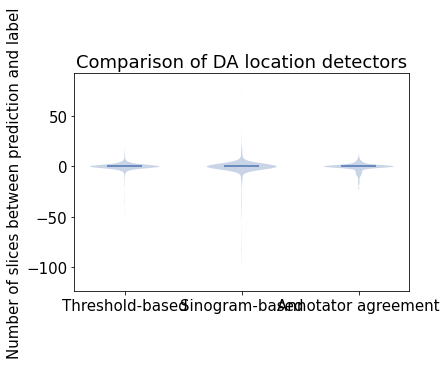

In [14]:
""" Violin plot for location data """
thr = loc_df["thr_delta"].dropna().values
sin = loc_df["sin_delta"].dropna().values
agr = double_labels["raw_diff"].values

means = [thr.mean(), sin.mean(), agr.mean()]
error = [thr.std(), sin.std(), agr.std()]
# mpl.style.use("classic")
plt.rc('font', family='sans-serif', size=15)

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_facecolor('white')

ax.violinplot([thr, sin, agr], [0,0.5,1], points=300, widths=0.3,
                      showmeans=False, showextrema=False, showmedians=True)
ax.set_xticks([0,0.5,1])
ax.set_xticklabels(["Threshold-based", "Sinogram-based", "Annotator agreement"])
ax.set_ylabel("Number of slices between prediction and label")
ax.set_title("Comparison of DA location detectors")
plt.rc('font', family='serif', size=15)
plt.show()





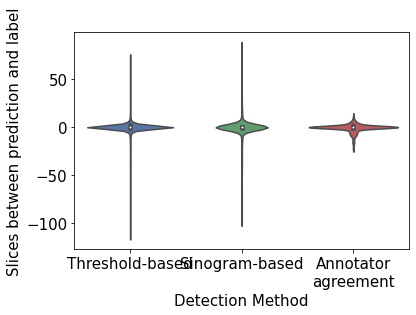

In [15]:
""" Seaborn Violin plots """
# mpl.style.use("classic")
# mpl.style.use("classic")
plt.rc('font', family='sans-serif', size=15)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6, 4])
fig.set_facecolor('white')
ax = sns.violinplot(data=[thr, sin, agr])
ax.set_xticklabels(["Threshold-based", "Sinogram-based", "Annotator\nagreement"])
ax.set_ylabel("Slices between prediction and label")
ax.set_xlabel("Detection Method")
plt.show()

Number of CNN test Images Used:  2319
Number of Strong:  946
Number of Weak:  606
Number of no DA:  767
TPR:  0.928479381443299 $\pm$ 0.8809523809523809 0.9694656488549618
FPR:  0.10039113428943937 $\pm$ 0.03277366472765733 0.1780821917808219
TNR:  0.8996088657105606 $\pm$ 0.819672131147541 0.9666666666666667
FNR:  0.07152061855670103 $\pm$ 0.030534351145038167 0.11765727124182991
AUC:  0.966737624161615 $\pm$ 0.9379971360790457 0.9880789587924932 , p= 0.0001999600079984003
MCC:  0.8193472821758218 $\pm$ 0.7314330508368979 0.8975855025750573 , p= 0.0001999600079984003


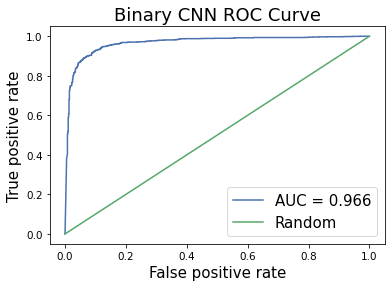

,SBD,CNN,3_class,2_class_annotation,3_class_annotation
TPR,0.656572,0.928479,NaN,NaN,NaN
FPR,0.074316,0.100391,NaN,NaN,NaN
TNR,0.925684,0.899609,NaN,NaN,NaN
FNR,0.343428,0.071521,NaN,NaN,NaN
MCC,0.549308,0.819347,NaN,0.902655,0.731852
MCC CI_l,0.447388,0.731433,NaN,0.829415,0.655603
MCC CI_u,0.642898,0.897586,NaN,0.963281,0.804244
AUC,0.791128,0.966738,NaN,NaN,NaN


In [16]:
""" Convolutional Neural Network Detection """

# # Remove images that were used in CNN training
# trg_data = pd.read_csv("/home/colin/Downloads/CNN_Full_preds.csv", 
#                        usecols=["patient_id", "isDuplicate"], 
#                        index_col="patient_id")
# test_data = pred_data[trg_data.loc[:, "isDuplicate"] == False]

# Print Some stats
print("Number of CNN test Images Used: ", len(test_data))
print("Number of Strong: ", sum(test_data["DA_mag"] == 2))
print("Number of Weak: ", sum(test_data["DA_mag"] == 1))
print("Number of no DA: ", sum(test_data["DA_mag"] == 0))

# Get performance metrics
metrics["CNN"] = get_metrics(test_data["bit_label"].values, 
                             test_data["CNN_pred"].values, 
                             scores=test_data["CNN_prob1"].values)

# mpl.style.use("classic")



# ROC curve
fpr, tpr, thresholds = roc_curve(test_data["bit_label"].values, 
                                 test_data["CNN_prob1"].values,
                                 pos_label=2)

fig = plt.figure()
fig.set_facecolor('white')
plt.rc('font', family='sans-serif', size=15)
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

plt.plot(fpr, tpr, label="AUC = "+str(metrics.loc["AUC", "CNN"])[:5])
plt.plot([0,0.5, 1], [0, 0.5, 1], label="Random")
plt.legend(loc="lower right")
plt.title("Binary CNN ROC Curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

metrics

## Building a 3-Class Classifier
![alt text](3_class_schematic.jpg "Schematic for a 3-class DA classifier")

In [17]:
""" 3-Class DA Classifier Results """
# Algorithm for 3 class
multi_pred = []
for pid in test_data.index.values :   # Use CNN test data
    sinogram = test_data.loc[pid, "bhk_pred"]
    cnn = test_data.loc[pid, "CNN_pred"]
    
    # Sinogram first
    if sinogram == 2 :
        if cnn == 2 : 
            multi_pred.append(2)
        else : # CNN = 0
            multi_pred.append(0)
    else : # Sinogram = 0
        if cnn == 2 :
            multi_pred.append(1)
        else : # CNN = 0
            multi_pred.append(0)
            

test_data.loc[:, "multi_pred"] = multi_pred

# Print stats
print("Number of test images: ", len(test_data))
print("Number of strong", sum(test_data["DA_mag"] == 2))
print("Number of weak", sum(test_data["DA_mag"] == 1))
print("Number of none", sum(test_data["DA_mag"] == 0), "\n")

print("MCC For 3-Class Classifier")
three_class_mcc, mcc_3c_p = permutation_test(test_data["DA_mag"], 
                                   test_data["multi_pred"],
                                   matthews_corrcoef)
mcc_ci = bootstrap_ci(test_data["DA_mag"], test_data["multi_pred"], matthews_corrcoef)[1 : ]
print(three_class_mcc, mcc_ci, mcc_3c_p)

# Add 3 class MCC to metrics df
metrics.loc["MCC", "3_class"] = three_class_mcc
metrics.loc["MCC CI_l", "3_class"] = mcc_ci[0]
metrics.loc["MCC CI_u", "3_class"] = mcc_ci[1]


/home/colin/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/colin/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Number of test images:  2319
Number of strong 946
Number of weak 606
Number of none 767 

MCC For 3-Class Classifier
0.7332320428931924 (0.6508297502369207, 0.8095040405914402) 0.0001999600079984003


In [18]:
metrics

,SBD,CNN,3_class,2_class_annotation,3_class_annotation
TPR,0.656572,0.928479,NaN,NaN,NaN
FPR,0.074316,0.100391,NaN,NaN,NaN
TNR,0.925684,0.899609,NaN,NaN,NaN
FNR,0.343428,0.071521,NaN,NaN,NaN
MCC,0.549308,0.819347,0.733232,0.902655,0.731852
MCC CI_l,0.447388,0.731433,0.650830,0.829415,0.655603
MCC CI_u,0.642898,0.897586,0.809504,0.963281,0.804244
AUC,0.791128,0.966738,NaN,NaN,NaN


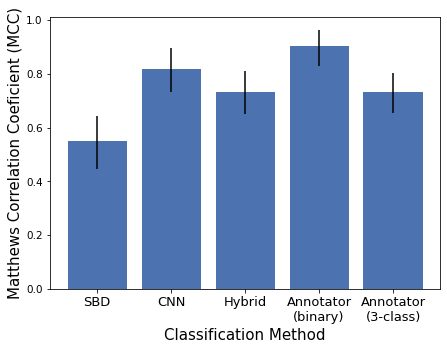

In [23]:

import matplotlib as mpl
# mpl.style.use('fast')
# mpl.style.use("classic")


plt.close('all')
plt.rc('font', family='sans-serif', size=15)
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
fig, ax = plt.subplots(figsize=[7, 5], facecolor="white")

# metrics.loc["MCC", :].plot.bar(color=["#59A14F", "#ECC539", "#AA6A99", "#519DBC", "#F08333"], 
#                                ax=ax)
error_bars = metrics.loc[["MCC CI_l","MCC CI_u"], :] - metrics.loc["MCC", :]
ax.bar([0, 1, 2, 3, 4], metrics.loc["MCC", :],  yerr=error_bars.abs().values)
# metrics.loc["MCC", :].plot.bar()
plt.ylabel("Matthews Correlation Coeficient (MCC)", fontsize=15)
plt.xlabel("Classification Method", fontsize=15)
plt.xticks([0, 1, 2, 3, 4], 
           ["SBD", "CNN", "Hybrid", "Annotator\n(binary)", "Annotator\n(3-class)"], fontsize=13)
plt.show()



In [20]:
""" Create other contingency tables"""
# Labeller agreement
print("Labeller Agreement")
print(pd.crosstab(double_labels["A_label"], double_labels["B_label"]), "\n")

# Sinogram detection
print("Sinogram binary detection")
print(pd.crosstab(pred_data["bit_label"], pred_data["bhk_pred"]), "\n")

# CNN detection
print("CNN binary detection")
print(pd.crosstab(test_data["bit_label"], test_data["CNN_pred"] ), "\n")

# Hybrid 3-class detection
print("Hybrid 3-class detection")
print(pd.crosstab(test_data["DA_mag"], test_data["multi_pred"]) )

Labeller Agreement
B_label    0   1    2
A_label              
0        114   1    4
1         11  51    0
2          2  65  234 

Sinogram binary detection
bhk_pred     0     2
bit_label           
0          959    71
2          784  1397 

CNN binary detection
CNN_pred     0     2
bit_label           
0          690    77
2          111  1441 

Hybrid 3-class detection
multi_pred    0    1    2
DA_mag                   
0           690   70    7
1            90  370  146
2            21   71  854
